In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf

import patsy

url_data = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"

## Columns: BI-RADS Assessment, Age, Shape, Margin, Density, Severity
names = ['BI-RADS', 'Age', 'Shape','Margin','Density','Severity']
data = pd.read_csv(url_data, header=None, names=names, na_values='?')
data = data.interpolate(method='linear', axis=0, inplace=False)

# COMP578 Data Mining Spring 2017
## Assignment 7

In this assignment you will be again using the [Mammographic Mass Data Set](http://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/).

### Task 1
##### 10 points

Train three models to predict `BI-RADS` based on polynomials of (respectively) `shape`, `margin`, and `density`.

Determine the best polynomial degree for each of the predictors separately - just like shown in the class.

Justify your selection.

Show the predictive capabilities of the models in a plot (use different color for each model).

Shape
   index  df_resid          ssr  df_diff   ss_diff         F    Pr(>F)
0      2     957.0  2939.561626      1.0  0.135341  0.044092  0.833728
1      3     956.0  2938.536590      1.0  1.025036  0.333937  0.563486
2      4     955.0  2931.420525      1.0  7.116065  2.318276  0.128193
3      1     958.0  2939.696967      1.0  7.927860  2.582743  0.108364
4      0     959.0  2947.624827      0.0       NaN       NaN       NaN
The best polynomial degree for ***Shape*** is: 3
The reason for this is that the probability for reaching the corresponding F value is highest at this degree of polynomial.


Margin
   index  df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0      4     955.0  2936.646479      1.0   0.377603  0.122797  0.726098
1      3     956.0  2937.024082      1.0   5.547857  1.804168  0.179528
2      1     958.0  2956.976767      1.0  10.364834  3.370653  0.066677
3      2     957.0  2942.571939      1.0  14.404828  4.684463  0.030683
4      0     959.0  2967.3

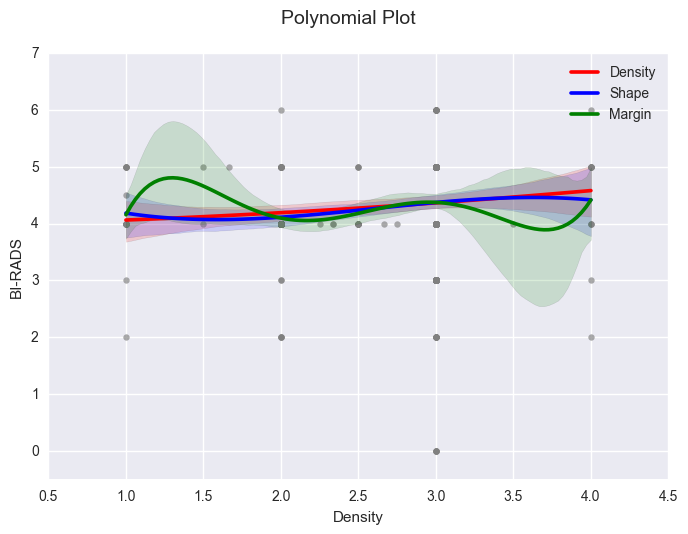

In [2]:
predictorsofinterest = ['Shape','Margin','Density']
target = 'BI-RADS'

X_container = {}
poly_container = {}

for predictor in predictorsofinterest:
    print(predictor)
    X1 = sklearn.preprocessing.PolynomialFeatures(1).fit_transform(data[predictor].values.reshape(-1,1))
    X2 = sklearn.preprocessing.PolynomialFeatures(2).fit_transform(data[predictor].values.reshape(-1,1))
    X3 = sklearn.preprocessing.PolynomialFeatures(3).fit_transform(data[predictor].values.reshape(-1,1))
    X4 = sklearn.preprocessing.PolynomialFeatures(4).fit_transform(data[predictor].values.reshape(-1,1))
    X5 = sklearn.preprocessing.PolynomialFeatures(5).fit_transform(data[predictor].values.reshape(-1,1))
    
    X_list = [X1,X2,X3,X4,X5]
    
    indextoX = {}
    for x in range (0,5):
        indextoX.update({x:X_list[x]})
        
    
    fit_1 = sm.GLS(data[target], X1).fit()
    fit_2 = sm.GLS(data[target], X2).fit()
    fit_3 = sm.GLS(data[target], X3).fit()
    fit_4 = sm.GLS(data[target], X4).fit()
    fit_5 = sm.GLS(data[target], X5).fit()

    fit_results = (sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, type=1))
    fit_results.sort_values(list(fit_results)[5],ascending=False,inplace=True)
    fit_results.reset_index(inplace=True)
    print(fit_results)
    
    bestX_index = fit_results.iloc[0]['index']
    
    X = indextoX[int(bestX_index)]

    print('The best polynomial degree for ***' + str(predictor) + '*** is: ' + str(int(bestX_index+1)))
    print('The reason for this is that the probability for reaching the corresponding F value is highest at this degree of polynomial.')
    print()
    print()
    
    X_container[predictor] = X
    poly_container[predictor] = int(bestX_index+1)

##Plot!
color_dict = {'Shape':'blue', 'Margin':'green','Density':'red'}
color_count = 0

fig, (ax1) = plt.subplots(1,1)
for key in poly_container:
    fit = sm.GLS(data[key],X_container[key]).fit()
    fit.summary()
    
    y = (data[target] > 2).map({False:0, True:1}).as_matrix()
    predictor_grid = np.arange(data[predictor].min(), data[target].max()).reshape(-1,1)
    X_test = sklearn.preprocessing.PolynomialFeatures(poly_container[key]).fit_transform(predictor_grid)
    
    clf = sklearn.linear_model.LogisticRegression(C=10**10, solver='lbfgs') 
    clf.fit(X_container[key], y)
    pred_sk = clf.predict_proba(X_test)
    
    clf = sm.GLM(y, X_container[key], family=sm.families.Binomial(sm.families.links.logit))
    res = clf.fit()
    pred_sm = res.predict(X_test)
    
    # creating plots
    fig.suptitle('Polynomial Plot', fontsize=14)

    # Scatter plot with polynomial regression line
    sns.regplot(data[predictor], data[target], order = poly_container[key], truncate=True, 
                scatter=True, 
                scatter_kws={'color':'gray', 'edgecolor':'k', 'alpha':0.3}, # passed to scatter()
                line_kws={'color':color_dict[key],'label':key},
                ax=ax1)
    
    ax1.set_ylim(-0.5,7)
    color_count = color_count + 1
plt.legend()
plt.show()

Based on this plot, I would posit that Density and Shape are the stronger predictors of BI-RADS. The graph for Margin may represent an overfitting.

### Task 2
##### 10 points

Predict the chances of getting cancer (i.e., `severity`) as a function of `age` using step functions.

In [3]:
def stepfunctions(data,predictor,target):
    df_cut, bins = pd.cut(data[predictor], 10, retbins=True, right=True)
    df_steps = pd.concat([data[predictor], df_cut, data[target]], keys=[predictor,'cuts',target], axis=1)
    df_steps_dummies = pd.get_dummies(df_steps['cuts'])
    glm_regr = sm.GLM(df_steps[target], df_steps_dummies, axis=1).fit()
    print(glm_regr.summary())
    
    predictor_grid = np.arange(data[predictor].min(), data[predictor].max()).reshape(-1,1)
    
    bin_mapping = np.digitize(predictor_grid.ravel(), bins)
    X_test = pd.get_dummies(bin_mapping)
    y = (data[target] == 1).map({False:0, True:1}).as_matrix()
    pred1 = glm_regr.predict(X_test)
    clf = sm.GLM(y, df_steps_dummies,
              family=sm.families.Binomial(sm.families.links.logit))
    res = clf.fit()
    pred2 = res.predict(X_test)
    
    ### creating plots
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    fig.suptitle('Piecewise Constant', fontsize=14)

    # Scatter plot with polynomial regression line
    ax1.scatter(data[predictor], data[target], facecolor='None', edgecolor='k', alpha=0.3)
    ax1.plot(predictor_grid, pred1, c='b')

    ax1.set_xlabel(predictor)
    ax1.set_ylabel(target)
    ax1.set_ylim(ymin=0)

    ax2.plot(np.arange(data[predictor].min(), data[predictor].max()).reshape(-1,1), pred2, color='b')


    ax2.scatter(data[predictor], y/5, s=30, c='grey', marker='|', alpha=0.7)

    ax2.set_ylim(0,1.2)
    ax2.set_xlabel(predictor)
    ax2.set_ylabel(target)
    plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Severity   No. Observations:                  961
Model:                            GLM   Df Residuals:                      951
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                  0.204017657582
Method:                          IRLS   Log-Likelihood:                -594.80
Date:                Tue, 14 Mar 2017   Deviance:                       194.02
Time:                        10:34:29   Pearson chi2:                     194.
No. Iterations:                     4                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
(17.922, 25.8]          0      0.084          0      1.000        -0.164     0.164
(25.8, 33.6]       0.0976      0.071    

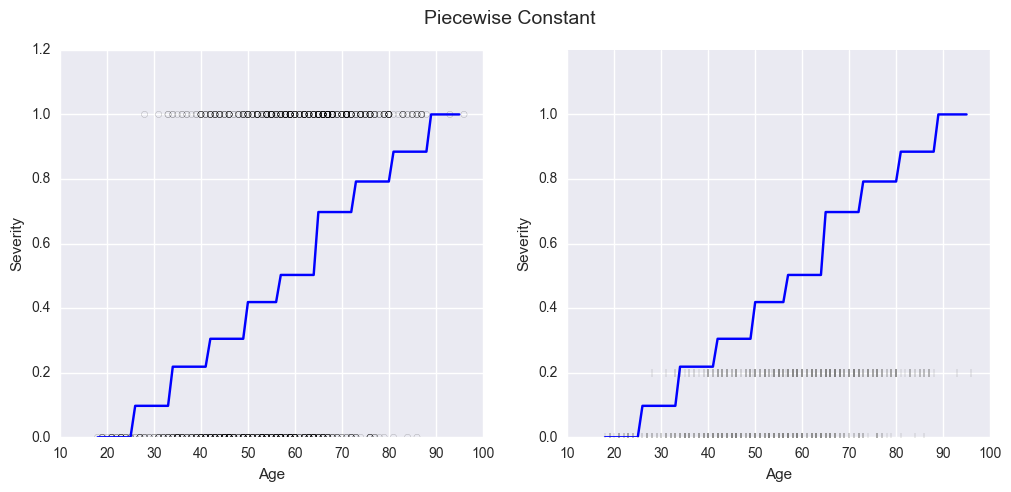

In [4]:
target = 'Severity'
predictor = 'Age'
stepfunctions(data,predictor,target)

From these stepwise graphs it is quite apparent that there is a strong correlation between Age and Severity.

### Task 3
##### 10 points

Try at least three splines to build a model to predict BI-RADS based on age.

Compare the predictive capabilities of the models in a plot (use different color for each model).

You may go outside of what was used in the class - just explain what you use. As we stated in the class, there are some splines also in SciPy.

In [5]:
def usesplines(data,predictor,target):
    predictor_grid = np.arange(data[predictor].min(), data[predictor].max()).reshape(-1,1)

    
    transformed_x3_3 = patsy.dmatrix("bs(data[predictor], knots=(30,50,60), degree=3, include_intercept=False)",
                            {"data[predictor]": data[predictor]}, return_type='dataframe')
    fit = sm.GLM(data[target], transformed_x3_3).fit()
    pred_x3_3 = fit.predict(patsy.dmatrix("bs(predictor_grid, knots=(30,50,60), degree=3, include_intercept=False)",
                                 {"predictor_grid": predictor_grid}, return_type='dataframe'))
    
    transformed_x3_6 = patsy.dmatrix("bs(data[predictor], df=6, degree=3, include_intercept=False)",
                            {"data[predictor]": data[predictor]}, return_type='dataframe')
    fit = sm.GLM(data[target], transformed_x3_6).fit()
    pred_x3_6 = fit.predict(patsy.dmatrix("bs(predictor_grid, df=6, degree=3, include_intercept=False)",
                                 {"predictor_grid": predictor_grid}, return_type='dataframe'))
    
    # Specifying 4 degrees of freedom
    transformed_x3_4 = patsy.dmatrix("cr(data[predictor], df=4)", {"data[predictor]": data[predictor]}, return_type='dataframe')
    fit = sm.GLM(data[target], transformed_x3_4).fit()
    pred_x3_4 = fit.predict(patsy.dmatrix("cr(predictor_grid, df=4)", {"predictor_grid": predictor_grid}, return_type='dataframe'))
    fit.params
    
    plt.scatter(data[predictor], data[target], facecolor='None', edgecolor='k', alpha=0.3)
    plt.plot(predictor_grid, pred_x3_3, color='b', label='Specifying three knots')
    plt.plot(predictor_grid, pred_x3_6, color='r', label='Specifying df=6')
    plt.plot(predictor_grid, pred_x3_4, color='g', label='Natural spline df=4')
    [plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [30,50,60]]
    plt.legend(bbox_to_anchor=(1.5, 1.0))
    plt.xlim(15,98)
    plt.ylim(-1,7)
    plt.xlabel(predictor)
    plt.ylabel(target);
    plt.show()

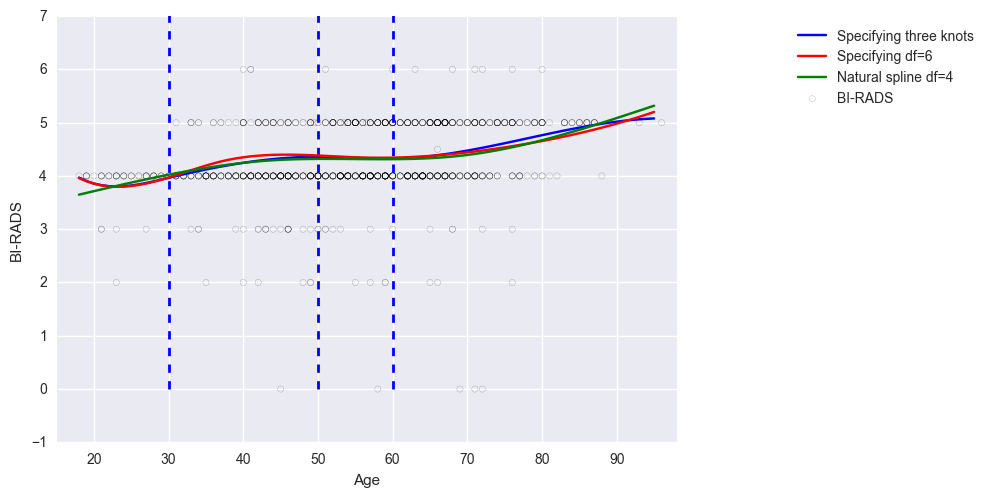

In [6]:
target = 'BI-RADS'
predictor = 'Age'
usesplines(data,predictor,target)